# Implement Value at Risk & Conditional Value at Risk using:

<b> YouTube Tutorial </b> (Published: Nov 24, 2020): https://youtu.be/04Tv6ZKqABs


    1. Historical Method
    2. Parametric Method (Variance-Covariance)
    3. Monte Carlo Method


## Get the Historical Data
First let's import the dependencies and get the data! We also assign random weightings to the given stock portfoio. Please feel free to change these weightings to whatever allocation you'd like!

In [ ]:
## This is required for pandas_datareader on google colab - then you need to restart runtime
!pip install --upgrade pandas_datareader

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import matplotlib.pyplot as plt

In [3]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock+'.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna() # Drop NaN values caused by pct_change() che sono la prima riga del dataframe

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights) # Normalize weights to sum to 1

returns['portfolio'] = returns.dot(weights) #dot product

returns

[*********************100%***********************]  6 of 6 completed


Ticker,BHP.AX,CBA.AX,NAB.AX,STO.AX,TLS.AX,WBC.AX,portfolio
Date,,,,,,,
2022-10-04 00:00:00+00:00,0.038083,0.046132,0.039680,0.041841,0.002604,0.040291,0.039689
2022-10-05 00:00:00+00:00,0.010731,0.026374,0.021426,0.018742,0.000000,0.033598,0.022063
2022-10-06 00:00:00+00:00,0.006420,-0.004214,-0.007866,0.018397,0.005195,-0.009481,0.005279
2022-10-07 00:00:00+00:00,-0.017174,-0.004748,-0.004295,0.019355,-0.007752,-0.002735,0.003308
2022-10-10 00:00:00+00:00,0.000250,-0.015142,-0.016589,-0.010127,-0.005208,-0.013711,-0.009476
...,...,...,...,...,...,...,...
2024-12-03 00:00:00+00:00,-0.001474,-0.002592,0.007634,0.004525,0.010101,0.010219,0.005556
2024-12-04 00:00:00+00:00,0.009592,-0.005387,-0.013636,0.012012,-0.005000,-0.015472,0.000816
2024-12-05 00:00:00+00:00,-0.011206,0.006755,-0.003072,-0.010386,0.005025,0.004533,-0.004783


## Historical VaR

YouTube Tutorial (Published:
Nov 25, 2020): https://youtu.be/90DeUSZ9fEk

Here we make no assumptions about the distribution of returns.

In [30]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        #Computes a single scalar value
        return np.percentile(returns, alpha) #The function calculates the 5th percentile of the returns data (che è unoa stock). In financial terms, 
    #this represents the Value at Risk (VaR) for the portfolio or asset at a 95% confidence level (since 5% is the complement of 95%).

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        #Returns: A Series where: the index is the column names (e.g., stock tickers) and the values are the VaR (a single number for each column).
        return returns.aggregate(historicalVaR, alpha=alpha) #aggregate applies the historicalVaR function to each column of the DataFrame returns, passing the alpha parameter to the function

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha) # aggregate applies the historicalCVaR function to each column of the DataFrame returns, passing the alpha parameter to the function

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 100

#For returns['portfolio']
#Since returns['portfolio'] is a Series (the portfolio's daily returns):
#historicalVaR(returns['portfolio'], alpha=5) returns a single number (VaR for the portfolio).
#historicalCVaR(returns['portfolio'], alpha=5) returns a single number (CVaR for the portfolio).
#For returns (Full DataFrame)
#If you pass the full DataFrame (returns) to historicalVaR or historicalCVaR:
#The .aggregate method applies the calculations column by column.
#It returns a Series with VaR or CVaR for each individual stock.

#The square root scaling is used to approximate how risk (like VaR) scales with time, assuming 
#returns are independent and identically distributed (IID). This is based on the property of standard deviation scaling in finance
hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time) #Scales the VaR for the 100-day period assuming returns are independent and identically distributed
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       408.41
Value at Risk 95th CI    :       1227.54
Conditional VaR 95th CI  :       1694.41


nella funzione portfolio performance hai parametri:
- weights: The allocation of capital to each asset.
- meanReturns: The average daily returns for each asset.
- covMatrix: The covariance matrix of returns, capturing the relationships between asset volatilities.
- Time: The number of days

outputs:

- pRet: Expected portfolio return over the 100-day horizon.
- pStd: Portfolio standard deviation (volatility) over the same period.

## Parametric VaR

YouTube Tutorial (Published: Dec 11, 2020): https://youtu.be/bTZP86fHIuI

Here we make an assumption on the distribution of returns abd use the historical portfolio returns and standard deviations (estimates) to define parameters for the model. Here we have implemented two parametric VaR models:
 - normal distribution
 - t-distribution (fatter tails)

In [31]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       808.1
Normal CVaR 95th CI      :       1117.15
t-dist VaR 95th CI       :       765.02
t-dist CVaR 95th CI      :       1186.26


Interpretation:

Normal VaR and CVaR: These assume that portfolio returns follow a normal distribution, which is simpler but may underestimate extreme risks.
t-Distribution VaR and CVaR: These account for heavier tails (more extreme events), making them more realistic for financial returns, which often exhibit fat-tailed behavior.

## Monte Carlo VaR & CVaR

YouTube Tutorial (Published: Mar 26, 2021): https://youtu.be/f9MAFvP5-pA

In this section we use a Monte Carlo simulation of a stock portfolio and then use the functions for historical VaR and CVaR to calculate our risk parameters.

The main advantage here is we could define individual models/stock dynamics for individual assets. This can be very powerful!

In [32]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

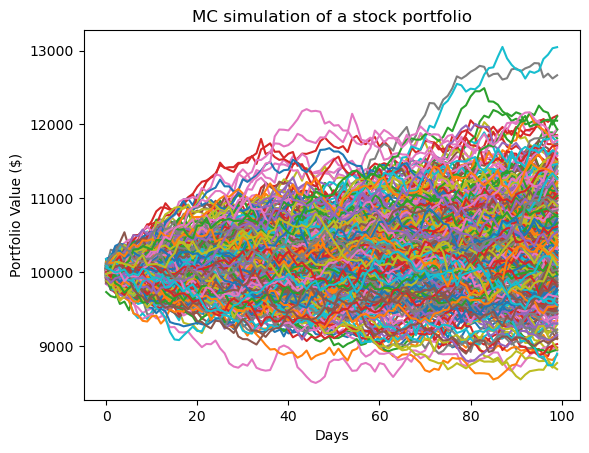

In [33]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [34]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [35]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $696.54
CVaR $965.1


## Comparison of each VaR & CVaR methods

In [36]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       1227.54
 Normal VaR 95th CI       :       808.1
 t-dist VaR 95th CI       :       765.02
 MC VaR  95th CI          :       696.54

CVaR:
 historical CVaR 95th CI  :       1694.41
 Normal CVaR 95th CI      :       1117.15
 t-dist CVaR 95th CI      :       1186.26
 MC CVaR 95th CI          :       965.1
